### Corona trends

This notebook includes scrapping data from CDS, estimating trends, and output the trends in a CSV file.

Data is from [Corona Data Scraper](https://coronadatascraper.com/#home)

the libraries in this file can be all found in [this image](https://hub.docker.com/repository/docker/pipcourbois/tensorflow-notebook-plus)


In [1]:
import numpy as np
import pandas as pd

In [2]:
rawtimeseries = pd.read_csv('https://coronadatascraper.com/timeseries.csv', parse_dates=['date'])

display('Timeseries:')
display(rawtimeseries.head())

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


'Timeseries:'

,name,level,city,county,state,country,population,lat,long,url,...,recovered,active,tested,hospitalized,hospitalized_current,discharged,icu,icu_current,growthFactor,date
0,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-22
1,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-23
2,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-24
3,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-25
4,"Antwerp, Flanders, Belgium",county,NaN,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2020-01-26


### USA county-level data

In [3]:
USA = rawtimeseries[(rawtimeseries.country == 'United States') & (rawtimeseries.level == 'county')]

In [4]:
len(USA)

321004

In [5]:
USA.dtypes

name                            object
level                           object
city                            object
county                          object
state                           object
country                         object
population                     float64
lat                            float64
long                           float64
url                             object
aggregate                       object
tz                              object
cases                          float64
deaths                         float64
recovered                      float64
active                         float64
tested                         float64
hospitalized                   float64
hospitalized_current           float64
discharged                     float64
icu                            float64
icu_current                    float64
growthFactor                   float64
date                    datetime64[ns]
dtype: object

#### Don't need all these fields

In [79]:
f=USA[['date','state','county','cases','deaths','hospitalized','tested','population']]

In [80]:
f.set_index(['state','county','date']).head()

cases  deaths  hospitalized  tested  \
state  county        date                                              
Nevada Washoe County 2020-03-05    1.0     NaN           NaN     NaN   
                     2020-03-06    1.0     NaN           NaN     NaN   
                     2020-03-07    1.0     NaN           NaN     NaN   
                     2020-03-08    2.0     NaN           NaN     NaN   
                     2020-03-09    2.0     NaN           NaN     NaN   

                                 population  
state  county        date                    
Nevada Washoe County 2020-03-05    471519.0  
                     2020-03-06    471519.0  
                     2020-03-07    471519.0  
                     2020-03-08    471519.0  
                     2020-03-09    471519.0

### Pull FIPS codes

In [81]:
geo_codes = pd.read_excel('https://www2.census.gov/programs-surveys/popest/geographies/2017/all-geocodes-v2017.xlsx'
                             , skiprows = 5
                             ,header=None
                             ,converters={0:str,1:str,2:str,3:str,4:str,5:str,6:str}
                            )

geo_codes.columns = ['level','statefips','countyfips','drop1','drop2','drop3','county']

In [82]:
geo_codes.dtypes

level         object
statefips     object
countyfips    object
drop1         object
drop2         object
drop3         object
county        object
dtype: object

In [83]:
county_codes = geo_codes[geo_codes['level'] == '050'].drop(columns=['level','drop1','drop2','drop3'])
state_codes = geo_codes[geo_codes['level'] == '040'].drop(columns=['level','countyfips','drop1','drop2','drop3']).rename(columns = {'county':'state'})

In [84]:
county_codes = pd.merge(county_codes,state_codes,how='inner',on='statefips')

In [85]:
county_codes['geo_id'] = county_codes["statefips"] + county_codes["countyfips"]
county_codes.drop(columns = ['statefips','countyfips'],inplace=True)

### merge codes with corona data

In [86]:
f = pd.merge(f, county_codes,how='inner', on=['state','county'])

In [87]:
f.head()

,date,state,county,cases,deaths,hospitalized,tested,population,geo_id
0,2020-03-05,Nevada,Washoe County,1.0,NaN,NaN,NaN,471519.0,32031
1,2020-03-06,Nevada,Washoe County,1.0,NaN,NaN,NaN,471519.0,32031
2,2020-03-07,Nevada,Washoe County,1.0,NaN,NaN,NaN,471519.0,32031
3,2020-03-08,Nevada,Washoe County,2.0,NaN,NaN,NaN,471519.0,32031
4,2020-03-09,Nevada,Washoe County,2.0,NaN,NaN,NaN,471519.0,32031


In [88]:
# there are several wyoming counties
f[(f.state=='New York') & (f.county=='Wyoming County')].head()

,date,state,county,cases,deaths,hospitalized,tested,population,geo_id
201998,2020-03-17,New York,Wyoming County,1.0,NaN,NaN,NaN,39859.0,36121
201999,2020-03-18,New York,Wyoming County,1.0,NaN,NaN,NaN,39859.0,36121
202000,2020-03-19,New York,Wyoming County,2.0,NaN,NaN,NaN,39859.0,36121
202001,2020-03-20,New York,Wyoming County,2.0,NaN,NaN,NaN,39859.0,36121
202002,2020-03-21,New York,Wyoming County,2.0,NaN,NaN,NaN,39859.0,36121


### Data Cleaning

All the data are cumulative since beginning of recording. So we will have to do first-differencing to get the actual number of deaths per day.

The daily cumulative numbers have some inaccuracies: 
1. Have missing data at the beginning and center of timeseries. At the beginning of timeseries the NAs are zero (have not begun recording yet), in the center of a timeseries they cannot be zero.  
1. Have some cumulative numbers that drop from one day to the next.

We have to do the following
1. remove duplicates - two counties in Alaska are duplicated
1. Roll up to weekly  
1. Clean up NAs 
1. Clean up drops in cumulative numbers

Probably easiest to roll up to the weekly numbers first (not really a rollup, simply take the value for every Sunday since all the numbers are cumulative). This will aleviate some of the other issues. 

#### remove duplicates

Couple counties in Alaska have duplicate entries causing issues.

Easiest to remove using an index.

In [89]:
f=f.set_index(['geo_id','date'])
# keep the last one:
f[f.index.duplicated(keep='last')].sort_index()

state                     county  cases  deaths  \
geo_id date                                                           
02020  2020-03-24  Alaska     Anchorage Municipality   17.0     NaN   
       2020-03-25  Alaska     Anchorage Municipality   28.0     NaN   
       2020-03-26  Alaska     Anchorage Municipality   33.0     NaN   
       2020-03-27  Alaska     Anchorage Municipality   43.0     1.0   
       2020-03-28  Alaska     Anchorage Municipality   54.0     1.0   
       2020-03-29  Alaska     Anchorage Municipality   59.0     2.0   
       2020-03-30  Alaska     Anchorage Municipality   61.0     2.0   
       2020-03-31  Alaska     Anchorage Municipality   65.0     2.0   
       2020-04-01  Alaska     Anchorage Municipality   67.0     2.0   
02170  2020-03-24  Alaska  Matanuska-Susitna Borough    2.0     NaN   
       2020-03-25  Alaska  Matanuska-Susitna Borough    2.0     NaN   
       2020-03-26  Alaska  Matanuska-Susitna Borough    2.0     NaN   
       2020-03-27  Alaska  Matanuska-Susitna Borough    2.0     NaN   
       2020-03-28  Alaska  Matanuska-Susitna Borough    2.0     NaN   
       2020-03-29  Alaska  Matanuska-Susitna Borough    2.0     NaN   
       2020-03-30  Alaska  Matanuska-Susitna Borough    3.0     NaN   
       2020-03-31  Alaska  Matanuska-Susitna Borough    3.0     NaN   
       2020-04-01  Alaska  Matanuska-Susitna Borough    4.0     NaN   

                   hospitalized  tested  population  
geo_id date                                          
02020  2020-03-24           NaN     NaN    288000.0  
       2020-03-25           NaN     NaN    288000.0  
       2020-03-26           NaN     NaN    288000.0  
       2020-03-27           NaN     NaN    288000.0  
       2020-03-28           NaN     NaN    288000.0  
       2020-03-29           NaN     NaN    288000.0  
       2020-03-30           NaN     NaN    288000.0  
       2020-03-31           NaN     NaN    288000.0  
       2020-04-01           NaN     NaN    288000.0  
02170  2020-03-24           NaN     NaN    108317.0  
       2020-03-25           NaN     NaN    108317.0  
       2020-03-26           NaN     NaN    108317.0  
       2020-03-27           NaN     NaN    108317.0  
       2020-03-28           NaN     NaN    108317.0  
       2020-03-29           NaN     NaN    108317.0  
       2020-03-30           NaN     NaN    108317.0  
       2020-03-31           NaN     NaN    108317.0  
       2020-04-01           NaN     NaN    108317.0

In [90]:
f = f.loc[~f.index.duplicated(keep='first')]

In [91]:
f[f.index.duplicated(keep='last')].sort_index()

,,state,county,cases,deaths,hospitalized,tested,population
geo_id,date,,,,,,,


In [92]:
f.reset_index(inplace=True)

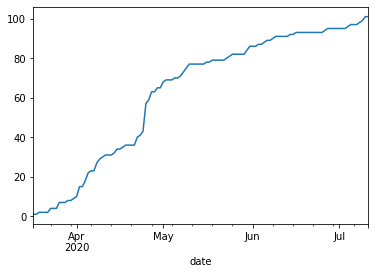

In [93]:
# this is stupid but need date index to get a good plot but I don't want to set index on f permanently because it is annoying later
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'cases'].plot()

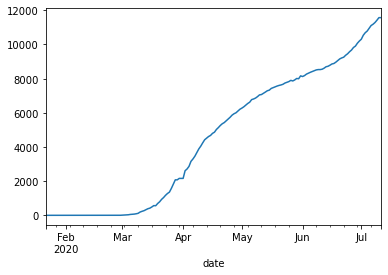

In [94]:
f[(f.state=='Washington') & (f.county=='King County')].set_index(['date']).loc[:,'cases'].plot()

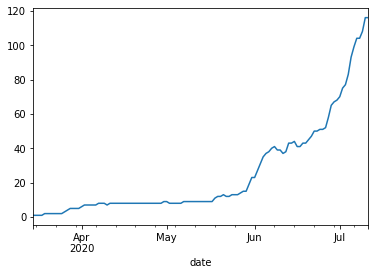

In [95]:
f[(f.state=='North Carolina') & (f.county=='Watauga County')].set_index(['date']).loc[:,'cases'].plot()

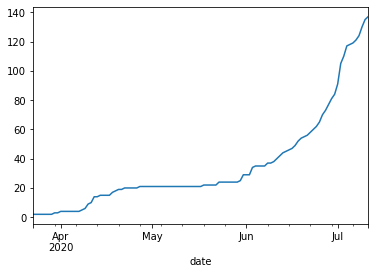

In [96]:
f[f.geo_id == '02170'].set_index(['date']).loc[:,'cases'].plot()

#### Missing values 

There are two types of missing values that I want to treat differently: 
1. Missing values at the beginning of a time series 
2. Missing values within a time series

Wyoming County is a good example of both of these.

I will transform these as follows:
1. fill in initial NAs with zero 
1. fill in with the most recent cumulative count (presumably the day before)

Because of the way the fillna code works, we are going to do these in the opposite order (start with step \#2).

In [97]:
# this is step 2, fill with the prior day (or most recent day without NA)
# inital NAs will still be NA
# note: this is not going to backfill to all counties having same start date
f = f.groupby('county',as_index=False).fillna(method='ffill')

In [98]:
# this is step #1 fill remainder of NAs with zero (will always be at beginning of timeseries)
f.fillna(0.0,inplace=True)

In [99]:
f[(f.state=='New York') & (f.county=='Wyoming County')]

,geo_id,date,state,county,cases,deaths,hospitalized,tested,population
201980,36121,2020-03-17,New York,Wyoming County,1.0,0.0,0.0,0.0,39859.0
201981,36121,2020-03-18,New York,Wyoming County,1.0,0.0,0.0,0.0,39859.0
201982,36121,2020-03-19,New York,Wyoming County,2.0,0.0,0.0,0.0,39859.0
201983,36121,2020-03-20,New York,Wyoming County,2.0,0.0,0.0,0.0,39859.0
201984,36121,2020-03-21,New York,Wyoming County,2.0,0.0,0.0,0.0,39859.0
...,...,...,...,...,...,...,...,...,...
202092,36121,2020-07-07,New York,Wyoming County,97.0,3.0,0.0,0.0,39859.0
202093,36121,2020-07-08,New York,Wyoming County,98.0,3.0,0.0,0.0,39859.0
202094,36121,2020-07-09,New York,Wyoming County,99.0,3.0,0.0,0.0,39859.0
202095,36121,2020-07-10,New York,Wyoming County,101.0,3.0,0.0,0.0,39859.0


In [ ]:
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'cases'].plot()

In [100]:
f[f.geo_id == '02170']

,geo_id,date,state,county,cases,deaths,hospitalized,tested,population
18406,02170,2020-03-23,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0
18407,02170,2020-03-24,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0
18408,02170,2020-03-25,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0
18409,02170,2020-03-26,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0
18410,02170,2020-03-27,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0
...,...,...,...,...,...,...,...,...,...
18512,02170,2020-07-07,Alaska,Matanuska-Susitna Borough,121.0,2.0,0.0,0.0,108317.0
18513,02170,2020-07-08,Alaska,Matanuska-Susitna Borough,124.0,2.0,0.0,0.0,108317.0
18514,02170,2020-07-09,Alaska,Matanuska-Susitna Borough,130.0,2.0,0.0,0.0,108317.0
18515,02170,2020-07-10,Alaska,Matanuska-Susitna Borough,135.0,2.0,0.0,0.0,108317.0


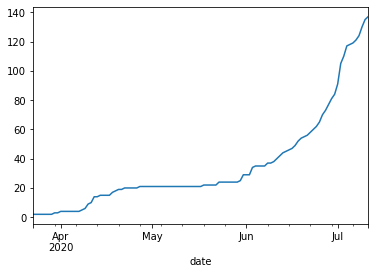

In [101]:
f[f.geo_id == '02170'].set_index(['date']).loc[:,'cases'].plot()

#### Filter to Saturdays

Create a filter for all the Saturdays. Cumulative data through the end of Saturdays.

In [102]:
# sundays = pd.date_range('2019-12-29', '2021-01-31', freq='W-SUN')
saturdays = pd.date_range('2019-12-28', '2021-01-30', freq='W-SAT')

In [103]:
f = f[f.date.isin(saturdays)]

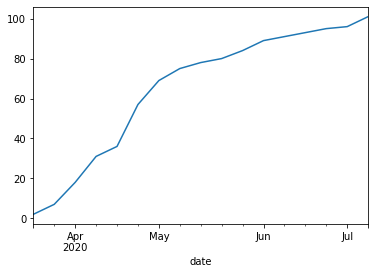

In [104]:
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'cases'].plot()

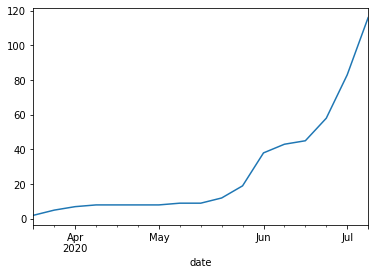

In [105]:
f[(f.state=='North Carolina') & (f.county=='Watauga County')].set_index(['date']).loc[:,'cases'].plot()

In [57]:
f[f.geo_id == '02170']

,geo_id,date,state,county,cases,deaths,hospitalized,tested,population
18411,02170,2020-03-28,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0
18418,02170,2020-04-04,Alaska,Matanuska-Susitna Borough,4.0,0.0,0.0,0.0,108317.0
18425,02170,2020-04-11,Alaska,Matanuska-Susitna Borough,10.0,0.0,0.0,0.0,108317.0
18432,02170,2020-04-18,Alaska,Matanuska-Susitna Borough,17.0,1.0,0.0,0.0,108317.0
18439,02170,2020-04-25,Alaska,Matanuska-Susitna Borough,20.0,1.0,0.0,0.0,108317.0
18446,02170,2020-05-02,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0
18453,02170,2020-05-09,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0
18460,02170,2020-05-16,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0
18467,02170,2020-05-23,Alaska,Matanuska-Susitna Borough,24.0,1.0,0.0,0.0,108317.0
18474,02170,2020-05-30,Alaska,Matanuska-Susitna Borough,25.0,1.0,0.0,0.0,108317.0


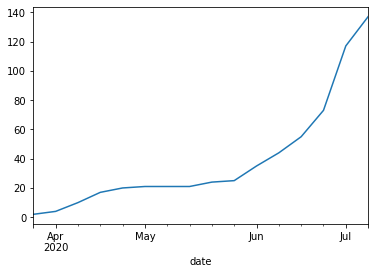

In [56]:
f[f.geo_id == '02170'].set_index(['date']).loc[:,'cases'].plot()

## Calculate "new" metrics  

Since all of the metrics are cumulative we need to calculate the "weekly-new" metrics.

In [58]:
f.dtypes

geo_id                  object
date            datetime64[ns]
state                   object
county                  object
cases                  float64
deaths                 float64
hospitalized           float64
tested                 float64
population             float64
dtype: object

In [106]:
# this should be run as a function and a loop but I am lazy
f['prev_value'] = f.groupby(['state','county'])['cases'].shift(1)
f['new_cases'] = f['cases']-f['prev_value']

f['prev_value'] = f.groupby(['state','county'])['deaths'].shift(1)
f['new_deaths'] = f['deaths']-f['prev_value']

f['prev_value'] = f.groupby(['state','county'])['hospitalized'].shift(1)
f['new_hospitalized'] = f['hospitalized']-f['prev_value']

f['prev_value'] = f.groupby(['state','county'])['tested'].shift(1)
f['new_tested'] = f['tested']-f['prev_value']

f.drop(columns=['prev_value'],inplace=True)

#once again fill in the NaNs
f.fillna(0.0,inplace=True)

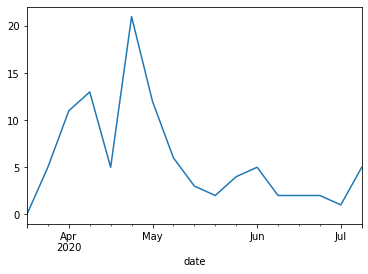

In [107]:
f[(f.state=='New York') & (f.county=='Wyoming County')].set_index(['date']).loc[:,'new_cases'].plot()

In [108]:
f[f.geo_id == '02170']

,geo_id,date,state,county,cases,deaths,hospitalized,tested,population,new_cases,new_deaths,new_hospitalized,new_tested
18411,02170,2020-03-28,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0,0.0,0.0,0.0,0.0
18418,02170,2020-04-04,Alaska,Matanuska-Susitna Borough,4.0,0.0,0.0,0.0,108317.0,2.0,0.0,0.0,0.0
18425,02170,2020-04-11,Alaska,Matanuska-Susitna Borough,10.0,0.0,0.0,0.0,108317.0,6.0,0.0,0.0,0.0
18432,02170,2020-04-18,Alaska,Matanuska-Susitna Borough,17.0,1.0,0.0,0.0,108317.0,7.0,1.0,0.0,0.0
18439,02170,2020-04-25,Alaska,Matanuska-Susitna Borough,20.0,1.0,0.0,0.0,108317.0,3.0,0.0,0.0,0.0
18446,02170,2020-05-02,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0,1.0,0.0,0.0,0.0
18453,02170,2020-05-09,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0,0.0,0.0,0.0,0.0
18460,02170,2020-05-16,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0,0.0,0.0,0.0,0.0
18467,02170,2020-05-23,Alaska,Matanuska-Susitna Borough,24.0,1.0,0.0,0.0,108317.0,3.0,0.0,0.0,0.0
18474,02170,2020-05-30,Alaska,Matanuska-Susitna Borough,25.0,1.0,0.0,0.0,108317.0,1.0,0.0,0.0,0.0


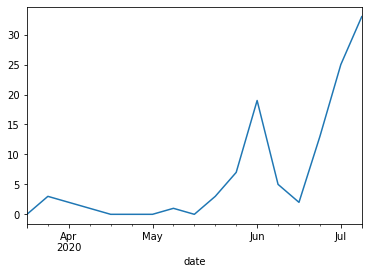

In [62]:
f[(f.state=='North Carolina') & (f.county=='Watauga County')].set_index(['date']).loc[:,'new_cases'].plot()

## Trends

1. Week over week 
1. Week over 4 week lag
2. Four week linear trend
3. Four week incident rate ratios <- need better name here

In [109]:
# use index this time
ft = f.set_index(['geo_id','date']).copy()

In [110]:
trend_vars = ['new_cases','new_deaths','new_hospitalized','new_tested']

In [111]:
def wow(df,column,new_column,lag):
    df = df.copy()
    new_column_pct = new_column + '_pct'
    df['prev_value'] = df.groupby(['geo_id'])[column].shift(lag)
    df[new_column] = df[column]-df['prev_value']
    df.loc[np.isnan(df[new_column]), new_column] = 0.0
    df[new_column_pct] = df[new_column]/df['prev_value']
    # fix missings and 0/0
    df.loc[np.isnan(df[new_column_pct]), new_column_pct] = 0.0
    # fix /0
    df.loc[~np.isfinite(df[new_column_pct]), new_column_pct] = 1.0
    df.drop(columns=['prev_value'],inplace=True)
    return df

In [112]:
for var in trend_vars:
    new_var = var + '_wow'
    print('{}'.format(new_var))
    ft = wow(ft,var,new_var,1)

new_cases_wow
new_deaths_wow
new_hospitalized_wow
new_tested_wow


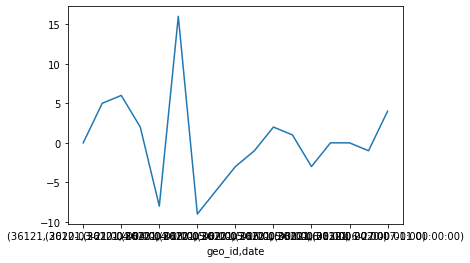

In [114]:
ft[(ft.state=='New York') & (ft.county=='Wyoming County')].loc[:,'new_cases_wow'].plot()

In [118]:
ft.loc['02170']

,state,county,cases,deaths,hospitalized,tested,population,new_cases,new_deaths,new_hospitalized,new_tested,new_cases_wow,new_cases_wow_pct,new_deaths_wow,new_deaths_wow_pct,new_hospitalized_wow,new_hospitalized_wow_pct,new_tested_wow,new_tested_wow_pct
date,,,,,,,,,,,,,,,,,,,
2020-03-28,Alaska,Matanuska-Susitna Borough,2.0,0.0,0.0,0.0,108317.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-04,Alaska,Matanuska-Susitna Borough,4.0,0.0,0.0,0.0,108317.0,2.0,0.0,0.0,0.0,2.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-11,Alaska,Matanuska-Susitna Borough,10.0,0.0,0.0,0.0,108317.0,6.0,0.0,0.0,0.0,4.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-18,Alaska,Matanuska-Susitna Borough,17.0,1.0,0.0,0.0,108317.0,7.0,1.0,0.0,0.0,1.0,0.166667,1.0,1.0,0.0,0.0,0.0,0.0
2020-04-25,Alaska,Matanuska-Susitna Borough,20.0,1.0,0.0,0.0,108317.0,3.0,0.0,0.0,0.0,-4.0,-0.571429,-1.0,-1.0,0.0,0.0,0.0,0.0
2020-05-02,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0,1.0,0.0,0.0,0.0,-2.0,-0.666667,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-09,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0,0.0,0.0,0.0,0.0,-1.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-16,Alaska,Matanuska-Susitna Borough,21.0,1.0,0.0,0.0,108317.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-23,Alaska,Matanuska-Susitna Borough,24.0,1.0,0.0,0.0,108317.0,3.0,0.0,0.0,0.0,3.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ft[(ft.state=='North Carolina') & (ft.county=='Watauga County')].loc[:,'new_cases_wow_pct'].plot()

### Average weekly trends

In [119]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def rolling_trend_linear(y):
    # this will be a slope per week, this X assumes all weeks are included
    x=np.arange(0,len(y),1).reshape(-1,1)
    regressor = LinearRegression()
    try:
        regressor.fit(x,y) 
    except:
        return 
    
    return regressor.coef_


# incomplete
def rolling_trend_loglinear(y):
    # this will be a slope per week, this X assumes all weeks are included
    x=np.arange(0,len(y),1).reshape(-1,1)
    regressor = LinearRegression()
    try:
        regressor.fit(x,y) 
    except:
        return 
    
    return regressor.coef_

In [130]:
ft2 = ft.copy()

In [133]:
ft2.reset_index(level=1)['date'].value_counts()

2020-07-11    3017
2020-07-04    3015
2020-06-27    3002
2020-06-20    2987
2020-06-13    2982
2020-06-06    2966
2020-05-23    2912
2020-05-16    2904
2020-05-30    2895
2020-05-09    2891
2020-05-02    2854
2020-04-25    2816
2020-04-18    2722
2020-04-11    2634
2020-04-04    2425
2020-03-28    1902
2020-03-21    1029
2020-03-14     370
2020-03-07      96
2020-02-29      23
2020-02-22      16
2020-02-15      13
2020-02-08      11
2020-02-01       8
2020-01-25       4
Name: date, dtype: int64

In [131]:
def apply_linear_trend(df,column,new_column,lag):
    df = df.copy()
    temp = df.rolling(lag)[column].apply(rolling_trend_linear)
    temp = temp.to_frame().rename(columns={column : new_column})    
    df = pd.merge(df,temp,how='left', on=['geo_id','date'])
    return df

In [132]:
# for some reason this loop is not working. It results in 65536

for var in trend_vars:
    new_var = var + '_4w_linear'
    ft2 = apply_linear_trend(ft2,var,new_var,4)
    print('{}'.format(new_var))
    ft2.reset_index(level=1)['date'].value_counts()

new_cases_4w_linear
new_deaths_4w_linear
new_hospitalized_4w_linear
new_tested_4w_linear


In [134]:
ft2.reset_index(level=1)['date'].value_counts()

2020-07-11    3017
2020-07-04    3015
2020-06-27    3002
2020-06-20    2987
2020-06-13    2982
2020-06-06    2966
2020-05-23    2912
2020-05-16    2904
2020-05-30    2895
2020-05-09    2891
2020-05-02    2854
2020-04-25    2816
2020-04-18    2722
2020-04-11    2634
2020-04-04    2425
2020-03-28    1902
2020-03-21    1029
2020-03-14     370
2020-03-07      96
2020-02-29      23
2020-02-22      16
2020-02-15      13
2020-02-08      11
2020-02-01       8
2020-01-25       4
Name: date, dtype: int64

#### Difference from 4-week average

In [172]:
ft3 = ft2.copy()

In [170]:
def apply_ma_diff(df,column):
    df = df.copy()
    ma_column = column+'_4w_ma'
    new_column = column + '_anomaly'
    temp = df.rolling(4)[column].mean()
    temp = temp.to_frame().rename(columns={column : ma_column})    
    df = pd.merge(df,temp,how='left', on=['geo_id','date'])
    # now take the lag and subtract
    df['prev_value'] = df.groupby(['geo_id'])[ma_column].shift(1)
    df[new_column] = df[column]-df['prev_value']
    df.drop(columns='prev_value',inplace=True)
    return df

In [173]:
ft3 = apply_ma_diff(ft3,'new_cases')
ft3 = apply_ma_diff(ft3,'new_deaths')
ft3 = apply_ma_diff(ft3,'new_hospitalized')
ft3 = apply_ma_diff(ft3,'new_tested')

In [174]:
df[['cases','new_cases','new_cases_4weeks','prev_value','new_cases_anomaly']]

cases  new_cases  new_cases_4weeks  prev_value  \
geo_id date                                                         
32031  2020-03-07    1.0        0.0               NaN         NaN   
       2020-03-14    4.0        3.0               NaN         NaN   
       2020-03-21   25.0       21.0               NaN         NaN   
       2020-03-28   93.0       68.0             23.00         NaN   
       2020-04-04  245.0      152.0             61.00       23.00   
...                  ...        ...               ...         ...   
56045  2020-06-13    1.0        0.0              1.00        1.25   
       2020-06-20    1.0        0.0              0.00        1.00   
       2020-06-27    1.0        0.0              0.00        0.00   
       2020-07-04    2.0        1.0              0.25        0.00   
       2020-07-11    1.0       -1.0              0.00        0.25   

                   new_cases_anomaly  
geo_id date                           
32031  2020-03-07               0.00  
       2020-03-14               0.00  
       2020-03-21               0.00  
       2020-03-28               0.00  
       2020-04-04             129.00  
...                              ...  
56045  2020-06-13              -1.25  
       2020-06-20              -1.00  
       2020-06-27               0.00  
       2020-07-04               1.00  
       2020-07-11              -1.25  

[46494 rows x 5 columns]

#### Export the data

In [175]:
ft3.reset_index(level=[0,1], inplace=True)

In [176]:
ft3.head()

,geo_id,date,state,county,cases,deaths,hospitalized,tested,population,new_cases,...,new_hospitalized_4w_linear,new_tested_4w_linear,new_cases_4w_ma,new_cases_anomaly,new_deaths_4w_ma,new_deaths_anomaly,new_hospitalized_4w_ma,new_hospitalized_anomaly,new_tested_4w_ma,new_tested_anomaly
0,32031,2020-03-07,Nevada,Washoe County,1.0,0.0,0.0,0.0,471519.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,32031,2020-03-14,Nevada,Washoe County,4.0,0.0,0.0,0.0,471519.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32031,2020-03-21,Nevada,Washoe County,25.0,0.0,0.0,0.0,471519.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,32031,2020-03-28,Nevada,Washoe County,93.0,0.0,0.0,0.0,471519.0,68.0,...,0.0,0.0,23.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,32031,2020-04-04,Nevada,Washoe County,245.0,4.0,0.0,0.0,471519.0,152.0,...,0.0,0.0,61.0,129.0,1.0,4.0,0.0,0.0,0.0,0.0


In [177]:
ft3['date'].value_counts()

2020-07-11    3017
2020-07-04    3015
2020-06-27    3002
2020-06-20    2987
2020-06-13    2982
2020-06-06    2966
2020-05-23    2912
2020-05-16    2904
2020-05-30    2895
2020-05-09    2891
2020-05-02    2854
2020-04-25    2816
2020-04-18    2722
2020-04-11    2634
2020-04-04    2425
2020-03-28    1902
2020-03-21    1029
2020-03-14     370
2020-03-07      96
2020-02-29      23
2020-02-22      16
2020-02-15      13
2020-02-08      11
2020-02-01       8
2020-01-25       4
Name: date, dtype: int64

In [178]:
ft3.to_csv('county_covid_health_trends.csv')
ft3[ft3['date'] == '2020-07-04'].to_csv('county_covid_health_trends_7-04.csv')